___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://facts.net/wp-content/uploads/2023/07/ASL-finger-signs--2048x1365.jpg" width="400px" height="180px" />


# <font color= #bbc28d> **PROYECTO FINAL** </font>
#### <font color= #2E9AFE> `Clasificación de Imágenes con Redes Neuronales`</font>
- <Strong> Diana Valdivia, Samantha Sánchez, Óscar Rocha, Viviana Toledo </Strong>
- <Strong> Fecha </Strong>: 18/05/2025



___

<p style="text-align:right;"> Imagen recuperada de: https://facts.net/wp-content/uploads/2023/07/ASL-finger-signs--2048x1365.jpg</p>

In [1]:
# Librerías Generales
import pandas as pd
import numpy as np
import os

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.image as mpimg

# Preprocesamiento
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Modelado - Redes Neuronales
import tensorflow as tf
# import tensorflow_hub as hub

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# <font color= #bbc28d> **Introducción** </font>

La lengua de señas es una herramienta esencial para la comunicación e inclusión de personas sordomudas, pues es el principal medio en el que pueden transmitir sus ideas y **hacerse escuchar** a través del cuerpo. Sin embargo, no todas las personas hablan este idioma y los signos varían según la región, lo que complica el proceso de aprendizaje y comprensión de la lengua de señas. 

Lo anterior resalta la necesidad de producir herramientas que faciliten la traducción del idioma, que interpreten las señas y permitan **cruzar la brecha lingüística** para no solo fomentar el uso de la lengua de señas, sino también eficientar el proceso de interpretación.

# <font color= #bbc28d> **Objetivo** </font>

- Elaborar una red neuronal capaz de identificar 3 letras del alfabeto de la Lengua de Señas Americana (ASL) a partir de una serie de imágenes, con la intención de traducir las señas y evaluar la posibilidad de escalar el modelo para el idioma en general.

# <font color= #bbc28d> **Análisis Exploratorio de Datos** </font>

Los datos para la elaboración de nuestro modelo fueron obtenidos de Kaggle, en la siguiente liga: https://www.kaggle.com/datasets/grassknoted/asl-alphabet?resource=download. 

El dataset contiene $3,000$ imágenes de $200 \times  200$ pixeles por cada letra del alfabeto ASL, así como para _Espacio_, _Borrar_ y _Nada_. Lo anterior resulta en un dataset de $29$ clases y $87,000$ imágenes, del cual, seleccionaremos tres señas para las letras **$D, O \space \text{y} \space G$**, debido a las diferencias marcadas entre las señas para cada una.

## <font color= #84a7b3> **Visualizar las Señas** </font>

<>:4: SyntaxWarning: invalid escape sequence '\C'
<>:4: SyntaxWarning: invalid escape sequence '\C'
C:\Users\diana\AppData\Local\Temp\ipykernel_17420\968384355.py:4: SyntaxWarning: invalid escape sequence '\C'
  carpeta = 'data\C'


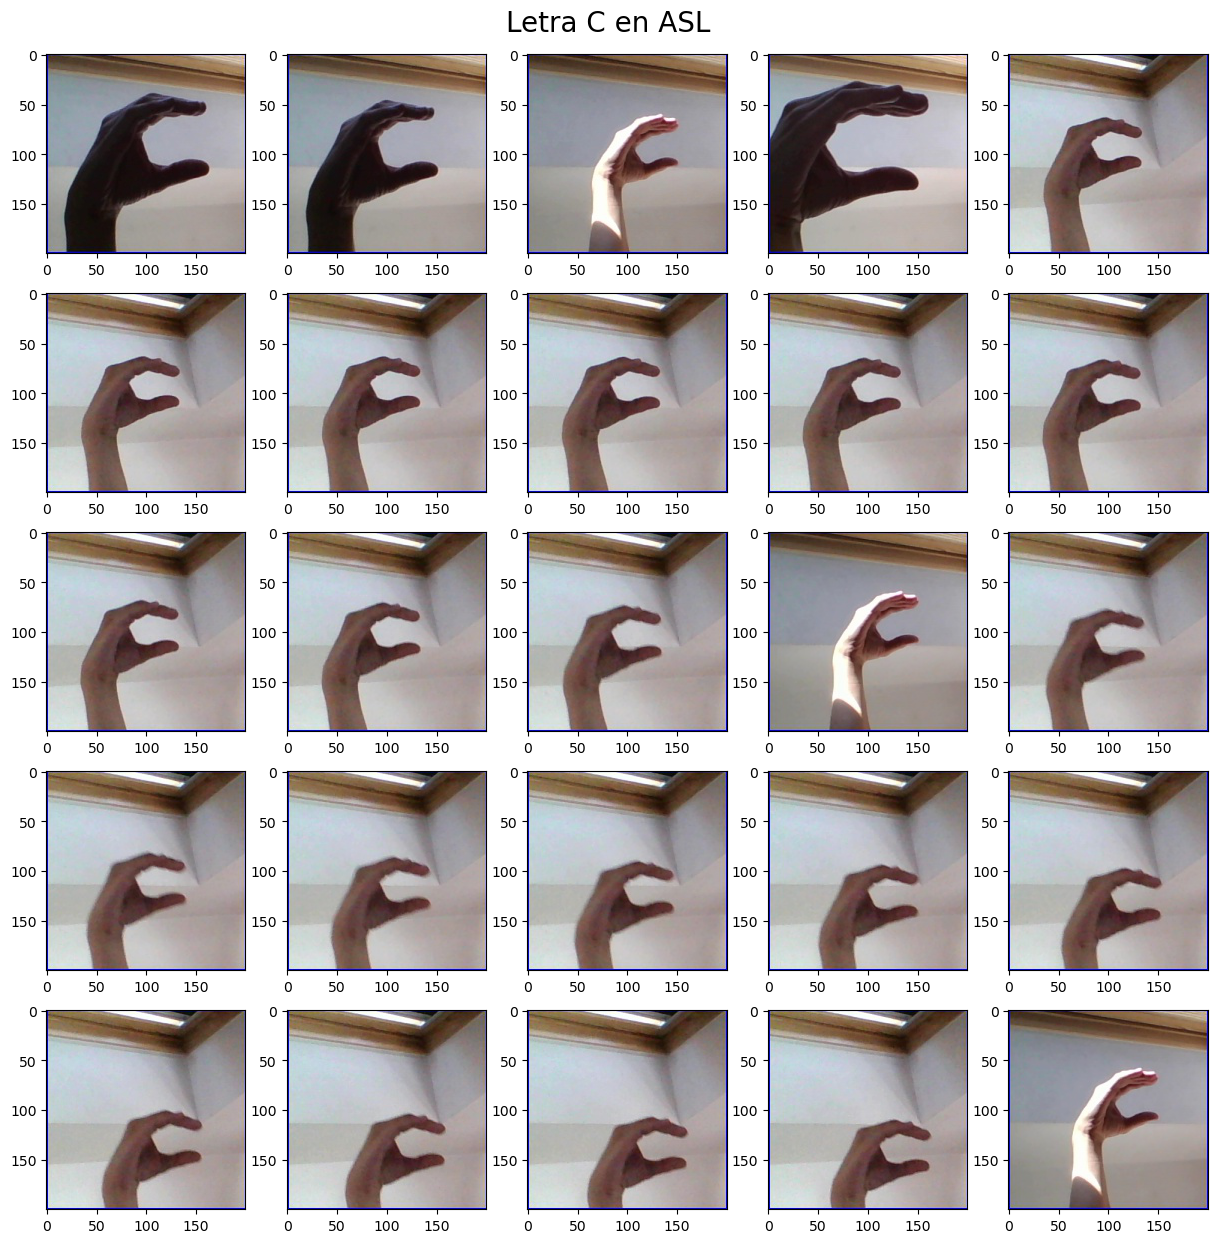

In [3]:
plt.figure(figsize=(15,15))
plt.suptitle('Letra C en ASL', fontsize=20, y=0.91)

carpeta = 'data\C'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

Explorando las imágenes disponibles en el dataset, podemos asumir que son fotografías tomadas de un vídeo o momento en el que se realizó la seña. Esto nos otorga diferentes ángulos y niveles de luz, sin embargo, también implica que hayan ciertas repeticiones o similitudes excesivas entre imágenes.

# <font color= #bbc28d> **Preprocesamiento** </font>

## <font color= #84a7b3> **Selección de Imágenes** </font>

Para evitar esperas largas en el entrenamiento de la red neuronal y evitar la similitud excesiva entre imágenes, seleccionaremos una muestra del $10 \% $ entre las $3,000$ fotografías disponibles.

In [ ]:
def img_selection(carpeta_fuente, letra):
    # Acceder a las imágenes
    imagenes = os.listdir(carpeta_fuente)
    # Definir la carpeta destino
    carpeta_destino = f'data/dataset/letra_{letra}'
    # Crear la carpeta destino si no existe
    os.makedirs(carpeta_destino, exist_ok=True)

    # Iterar sobre cada imagen y obtener el nombre
    for nombreimg in imagenes:
        # Si la imagen es un múltiplo de 10, seleccionarla y copiarla a las imágenes seleccionadas
        if nombreimg[-5] == "0":
            shutil.copy(os.path.join(carpeta_fuente, nombreimg),
                        os.path.join(carpeta_destino, nombreimg))

# Ejecutar para C, F, M
img_selection('data/C', 'C')
img_selection('data/F', 'F')
img_selection('data/M', 'M')    

In [2]:
#Mostrar cuantas imagenes tengo de cada categoria
print('Letras C:', len(os.listdir('data/dataset/letra_C' )))
print('Letras F:', len(os.listdir('data/dataset/letra_F' )))
print('Letras M:', len(os.listdir('data/dataset/letra_M' )))

Letras C: 300
Letras F: 300
Letras M: 300


## <font color= #84a7b3> **Introducción de Ruido** </font>

In [ ]:
#Crear el dataset generador que hace imagenes con transformaciones
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=15,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=15,
    zoom_range=0.2,
    validation_split=0.2
)

#Generadores para sets de entrenamiento y pruebas
# Se pide que sea estandarizado a 224x224
data_gen_entrenamiento = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

# <font color= #bbc28d> **Modelado** </font>